In [1]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

In [2]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


MNIST consists of 28x28 grayscale images unrolled onto 1 dimension.

In [3]:
28 * 28

784

Standardize X

In [4]:
X = ((X / 255.) - .5) * 2

Visualize a few digits

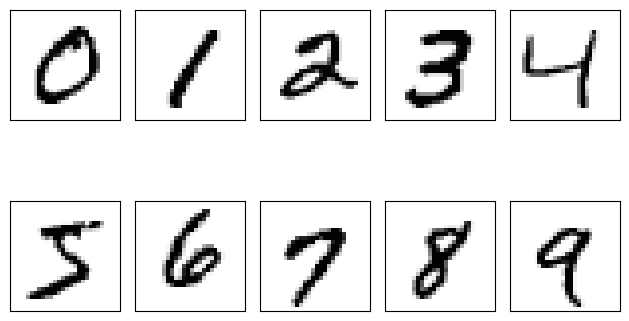

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()

for i in range(10):
    # y == i
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Display different images of the same digit.

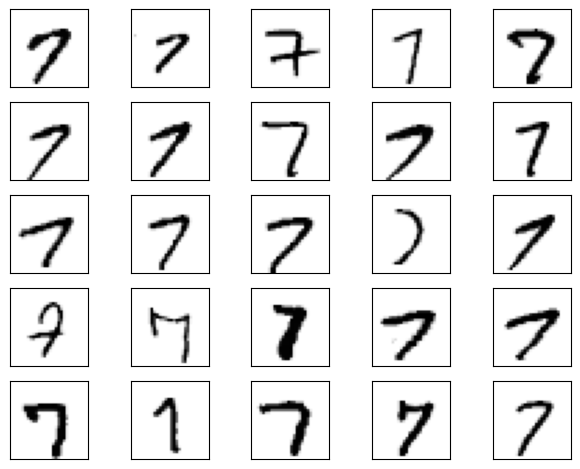

In [6]:
import numpy as np
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)

ax = ax.flatten()

# Select 10 examples of the digit 7
digit = 7
indices = np.where(y == digit)[0][:10]

for i in range(25):
    img = X[y==7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Split dataset: 55k for training, 5k for val, 10k for testing.

In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and remaining (validation + test)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=55000, random_state=42, stratify=y)

# Split the remaining dataset into validation and test
X_valid, X_test, y_valid, y_test = train_test_split(X_train, y_train, train_size=5000, test_size=10000, random_state=42, stratify=y_train)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_valid.shape}, {y_valid.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (55000, 784), (55000,)
Validation set: (5000, 784), (5000,)
Test set: (10000, 784), (10000,)


Implement neural net

In [9]:
import numpy as np

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, n_classes):
    m = y.shape[0]
    onehot = np.zeros((m, n_classes))
    onehot[np.arange(m), y] = 1
    return onehot

In [11]:
print(sigmoid(0))
print(int_to_onehot(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 10))

0.5
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [95]:
class NeuralNetNLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        # initialize weights and biases for input -> hidden
        # input shape: (num_features,)
        # weight shape: (num_features, num_hidden)
        # next layer shape: (num_hidden,)
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_features, num_hidden))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        # initialize weights and biases for hidden -> output
        # input shape: (num_hidden,)
        # weight shape: (num_hidden, num_classes)
        # next layer shape: (num_classes,)
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_classes))
        self.bias_out = np.zeros(num_classes)
    
    def forward(self, X):
        # input -> hidden
        z_h = np.dot(X, self.weight_h) + self.bias_h
        a_h = sigmoid(z_h)
        
        # hidden -> output
        z_out = np.dot(a_h, self.weight_out) + self.bias_out
        a_out = sigmoid(z_out)
        
        return a_h, a_out
    
    def backward(self, X, a_h, a_out, y):
        # Compute the gradient of the loss with respect to the output layer
        targets_onehot = int_to_onehot(y, self.num_classes)
        delta_out = (a_out - targets_onehot) * a_out * (1 - a_out)
        
        grad_weight_out = np.dot(a_h.T, delta_out)
        grad_bias_out = np.sum(delta_out, axis=0)
        
        # Compute the gradient of the loss with respect to the hidden layer
        delta_h = np.dot(delta_out, self.weight_out.T) * a_h * (1 - a_h)
        
        grad_weight_h = np.dot(X.T, delta_h)
        grad_bias_h = np.sum(delta_h, axis=0)
        
        return grad_weight_h, grad_bias_h, grad_weight_out, grad_bias_out

In [96]:
model = NeuralNetNLP(num_features=784, num_hidden=50, num_classes=10)

In [97]:
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    for start_idx in range(0, X.shape[0] - minibatch_size + 1, minibatch_size):
        excerpt = indices[start_idx:start_idx + minibatch_size]
        yield X[excerpt], y[excerpt]


In [98]:
num_epochs = 50
minibatch_size = 100

for i in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    
print(X_train_mini.shape, y_train_mini.shape)

(100, 784) (100,)


In [99]:
def mse_loss(targets, probas, num_labels=10):
    targets_onehot = int_to_onehot(targets, num_labels)
    loss = np.mean((targets_onehot - probas) ** 2)
    return loss

def accuracy(targets, predicted_labels):
    return np.mean(targets == predicted_labels)

In [100]:
_, probas = model.forward(X_train_mini)
loss = mse_loss(y_train_mini, probas)
print(f"Loss: {loss:.4f}")

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_train_mini, predicted_labels)
print(f"Accuracy: {acc:.4f}")

Loss: 0.2507
Accuracy: 0.0700


In [101]:
def train_model(model, X_train, y_train, X_valid, y_valid, num_epochs=50, minibatch_size=100, learning_rate=0.01):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        for X_train_mini, y_train_mini in minibatch_gen:
            # Forward pass
            a_h, a_out = model.forward(X_train_mini)
            
            # Backward pass
            grad_weight_h, grad_bias_h, grad_weight_out, grad_bias_out = model.backward(X_train_mini, a_h, a_out, y_train_mini)
            
            # Update weights and biases
            model.weight_h -= learning_rate * grad_weight_h
            model.bias_h -= learning_rate * grad_bias_h
            model.weight_out -= learning_rate * grad_weight_out
            model.bias_out -= learning_rate * grad_bias_out
        
        # Compute training loss and accuracy
        _, probas_train = model.forward(X_train)
        train_loss = mse_loss(y_train, probas_train)
        predicted_labels_train = np.argmax(probas_train, axis=1)
        train_acc = accuracy(y_train, predicted_labels_train)
        
        # Compute validation loss and accuracy
        _, probas_val = model.forward(X_valid)
        val_loss = mse_loss(y_valid, probas_val)
        predicted_labels_val = np.argmax(probas_val, axis=1)
        val_acc = accuracy(y_valid, predicted_labels_val)
        
        # Store the results
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_acc:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_acc:.4f}")
    
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [102]:
# Call the function to train the model
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, X_train, y_train, X_valid, y_valid)

Epoch 1/50 - Train Loss: 0.0195 - Train Accuracy: 0.8987 - Val Loss: 0.0195 - Val Accuracy: 0.8990
Epoch 2/50 - Train Loss: 0.0146 - Train Accuracy: 0.9191 - Val Loss: 0.0146 - Val Accuracy: 0.9204
Epoch 3/50 - Train Loss: 0.0127 - Train Accuracy: 0.9279 - Val Loss: 0.0126 - Val Accuracy: 0.9316
Epoch 4/50 - Train Loss: 0.0113 - Train Accuracy: 0.9364 - Val Loss: 0.0111 - Val Accuracy: 0.9378
Epoch 5/50 - Train Loss: 0.0107 - Train Accuracy: 0.9392 - Val Loss: 0.0105 - Val Accuracy: 0.9434
Epoch 6/50 - Train Loss: 0.0099 - Train Accuracy: 0.9444 - Val Loss: 0.0097 - Val Accuracy: 0.9458
Epoch 7/50 - Train Loss: 0.0093 - Train Accuracy: 0.9483 - Val Loss: 0.0091 - Val Accuracy: 0.9518
Epoch 8/50 - Train Loss: 0.0089 - Train Accuracy: 0.9508 - Val Loss: 0.0086 - Val Accuracy: 0.9528
Epoch 9/50 - Train Loss: 0.0082 - Train Accuracy: 0.9544 - Val Loss: 0.0079 - Val Accuracy: 0.9556
Epoch 10/50 - Train Loss: 0.0080 - Train Accuracy: 0.9557 - Val Loss: 0.0078 - Val Accuracy: 0.9562
Epoch 11/

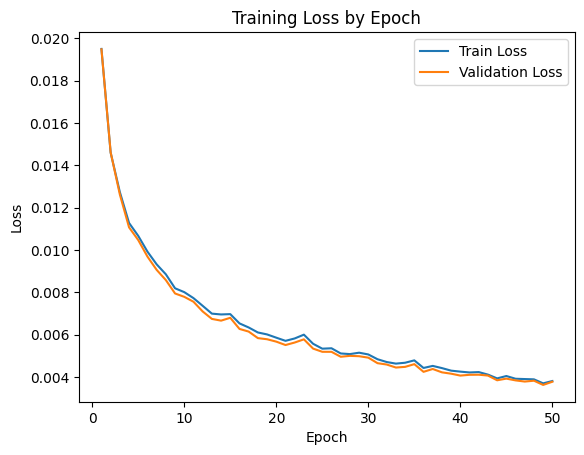

In [107]:
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss by Epoch')
plt.legend()
plt.show()

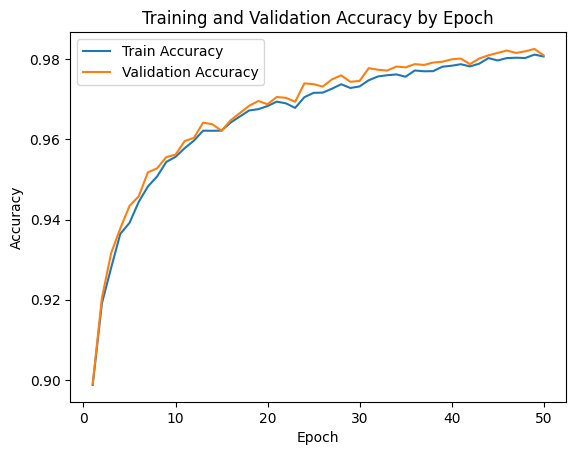

In [108]:
plt.plot(range(1, num_epochs + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy by Epoch')
plt.legend()
plt.show()

In [105]:
_, probas_test = model.forward(X_test)
predicted_labels_test = np.argmax(probas_test, axis=1)
test_acc = accuracy(y_test, predicted_labels_test)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9802


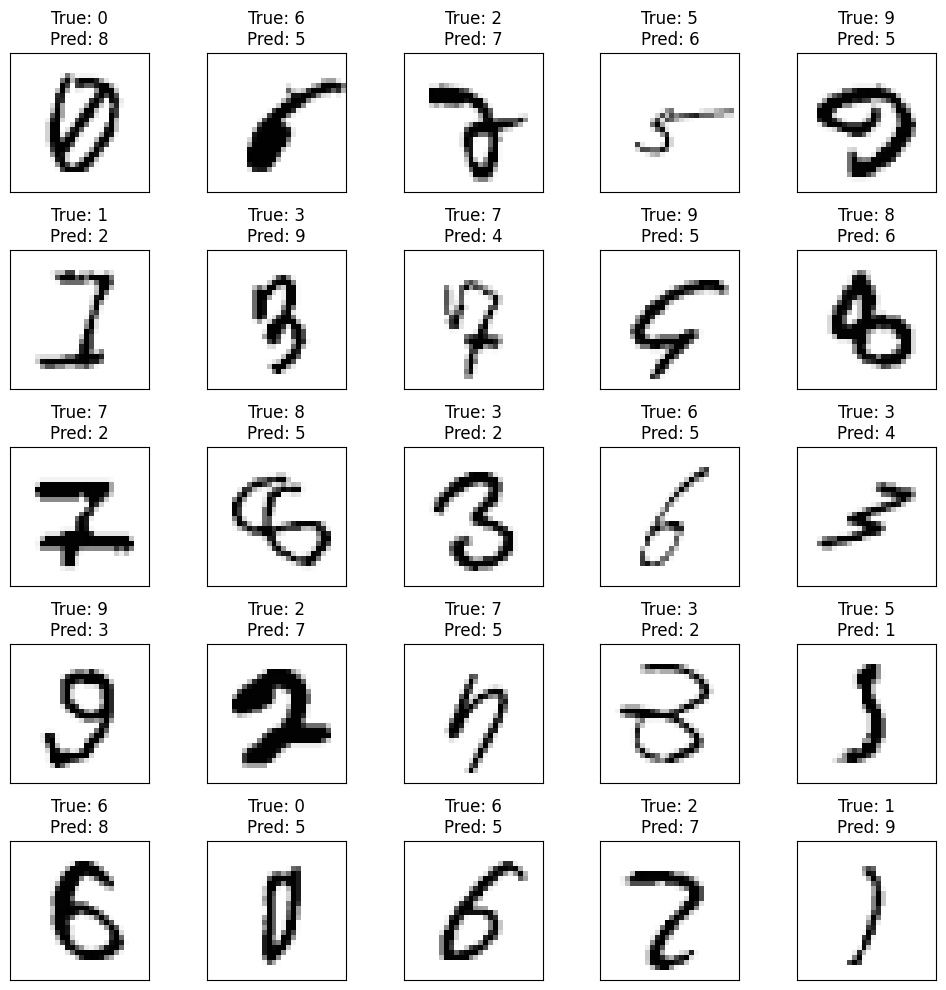

In [106]:
misclassified_indices = np.where(predicted_labels_test != y_test)[0]
misclassified_images = X_test[misclassified_indices]
misclassified_labels = predicted_labels_test[misclassified_indices]
true_labels = y_test[misclassified_indices]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(10, 10))
ax = ax.flatten()

for i in range(25):
    if i < len(misclassified_indices):
        img = misclassified_images[i].reshape(28, 28)
        ax[i].imshow(img, cmap='Greys')
        ax[i].set_title(f'True: {true_labels[i]}\nPred: {misclassified_labels[i]}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()